# Label Classifier (dSprites)

This notebook implement the original classifier and use its representation as shift detector. This method also known as Black Box Shift Detection (BBSD).

In [ ]:
## The following 3 cells are used to solve dependency problems
# !git clone https://github.com/steverab/failing-loudly.git
# %cd failing-loudly
# %pip install -r requirements.txt

In [ ]:
# %cd ..
# !git clone https://github.com/josipd/torch-two-sample.git
# %cd torch-two-sample
# !python setup.py install

In [ ]:
# !pip uninstall tensorflow
# !pip install tensorflow

In [3]:
import numpy as np
import torch
import random
# from torch_two_sample import *
from scipy.stats import ks_2samp, binom_test, chisquare, chi2_contingency, anderson_ksamp
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.io
from math import ceil
from copy import deepcopy
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from tensorflow.python import keras
from tensorflow.python.keras import layers

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Run utility functions
%run drive/MyDrive/Colab\ Notebooks/MPhil\ Prototype/Utilities.ipynb

## Load Dataset

In [6]:
# Load dataset, split into train test
path = 'drive/MyDrive/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
x_train, x_test, y_train, y_test, c_train, c_test = load_dsprites(path, 100000, train_size=0.85, class_index=1)

# Split training into validation set as well 
x_train, x_valid = x_train[:70000], x_train[70000:]
y_train, y_valid = y_train[:70000], y_train[70000:]
c_train, c_valid = c_train[:70000], c_train[70000:]

Training samples: 85000
Testing samples: 15000


In [7]:
# Reshape to appropriate shift input
# It is noteworthy that for efficiency, we represent the images as only 2 dimension
# when we preprocessing (number of instances/ batch size * flatten size).
# When visualising back the image, we need to reshape it back to the original dimension
ORIGINAL_SHAPE = x_test.shape[1:] # constant hold the image original shape
x_test_flatten = deepcopy(x_test.reshape(x_test.shape[0], -1))

## Apply Shifts
We apply shifts only to test data as discussed in the paper.


### Gaussian Shift

#### Large

In [8]:
shift = "large_gn_shift_1.0"
x_test_gaussian_large, y_test_gaussian_large = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Large GN shift


#### Medium

In [9]:
shift = "medium_gn_shift_1.0"
x_test_gaussian_medium, y_test_gaussian_medium = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Medium GN Shift


#### Small

In [10]:
shift = "small_gn_shift_1.0"
x_test_gaussian_small, y_test_gaussian_small = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Small GN Shift


### Image Shift

#### Large

In [11]:
shift = "large_img_shift_1.0"
x_test_img_large, y_test_img_small = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Large image shift


#### Medium

In [12]:
shift = "medium_img_shift_1.0"
x_test_img_medium, y_test_img_medium = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Medium image shift


#### Small

In [13]:
shift = "small_img_shift_1.0"
x_test_img_small, y_test_img_small = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Small image shift


### Knockout Shift

In [14]:
shift = "ko_shift_1.0"
x_test_ko, y_test_ko = apply_shift(deepcopy(x_test_flatten), y_test, shift, ORIGINAL_SHAPE) 

Large knockout shift


## BBSD: End to End Models

This section experiments on end-to-end models. We use the output of these models as the reduced representation before conducting the relevant statistical tests.

In [16]:
epochs = 200
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
batch_size = 128
num_classes = 3

end_to_end_model = NeuralNetworkClassifier(num_classes)
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
end_to_end_model.compile(loss="sparse_categorical_crossentropy",
                         metrics=["accuracy"],
                         optimizer=optimizer)

histories = end_to_end_model.fit(x=x_train, y=y_train,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_data=(x_valid, y_valid),
                                 callbacks=[lr_reducer, early_stopper])

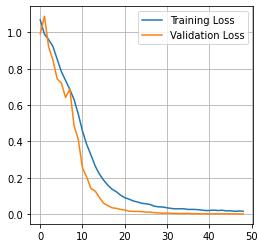

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

# Plot training validation loss
ax.plot(histories.history["loss"], label="Training Loss")
ax.plot(histories.history["val_loss"], label="Validation Loss")
ax.grid(True)
ax.legend()
plt.show()

In [ ]:
# Evaluate model
y_pred = end_to_end_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5021
           1       1.00      1.00      1.00      4957
           2       1.00      1.00      1.00      5022

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

[[5021    0    0]
 [   0 4957    0]
 [   0    0 5022]]


### BBSDs
Using the softmax outputs of the models as the reduced representation.

In [ ]:
## 1. Create reduce representation
# Valid data reduced representation
repr_valid = end_to_end_model.predict(x_valid)

In [ ]:
# Gaussian test reduced representation
repr_gaussian_large = end_to_end_model.predict(x_test_gaussian_large.reshape(len(x_test_gaussian_large), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2]))
repr_gaussian_medium = end_to_end_model.predict(x_test_gaussian_medium.reshape(len(x_test_gaussian_medium), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2]))
repr_gaussian_small = end_to_end_model.predict(x_test_gaussian_small.reshape(len(x_test_gaussian_small), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2]))

In [ ]:
# Image test reduced representation
repr_img_large = end_to_end_model.predict(x_test_img_large.reshape(len(x_test_img_large), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2]))
repr_img_medium = end_to_end_model.predict(x_test_img_medium.reshape(len(x_test_img_medium), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2]))
repr_img_small = end_to_end_model.predict(x_test_img_small.reshape(len(x_test_img_small), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2]))

In [ ]:
# Knockout reduced representation
repr_ko = end_to_end_model.predict(x_test_ko.reshape(len(x_test_ko), 
                                                    ORIGINAL_SHAPE[0], 
                                                    ORIGINAL_SHAPE[1],
                                                    ORIGINAL_SHAPE[2]))

In [ ]:
 ## Show new size 
 print(f"Size reduced valid: {repr_valid.shape}")
 print(f"Size reduced gaussian: {repr_gaussian_large.shape}")
 print(f"Size reduced img: {repr_img_medium.shape}")
 print(f"Size reduced ko: {repr_ko.shape}")

Size reduced valid: (15000, 3)
Size reduced gaussian: (15000, 3)
Size reduced img: (15000, 3)
Size reduced ko: (9979, 3)


#### Multiple Univariate Testing

In [ ]:
## Baseline (no-shift)
p_val, p_vals, t_vals = one_dimensional_test(repr_valid, repr_valid)
alpha = 0.05 / repr_valid.shape[1] # Divided by number of components for Bonferroni correction
print(f"Minimum p-value: {p_val}")
print(f"Component p-values: {p_vals}")
print(f"Test statistics: {t_vals}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

Minimum p-value: 1.0
Component p-values: [1. 1. 1.]
Test statistics: [-0.0, -0.0, -0.0]
Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.


In [ ]:
## Large Gaussian
p_val, p_vals, t_vals = one_dimensional_test(repr_gaussian_large, repr_valid)
alpha = 0.05 / repr_valid.shape[1] # Divided by number of components for Bonferroni correction
print(f"Minimum p-value: {p_val}")
print(f"Component p-values: {p_vals}")
print(f"Test statistics: {t_vals}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

Minimum p-value: 0.0
Component p-values: [0. 0. 0.]
Test statistics: [0.7466666666666667, 0.9482, 0.8993333333333333]
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Medium Gaussian
p_val, p_vals, t_vals = one_dimensional_test(repr_gaussian_medium, repr_valid)
alpha = 0.05 / repr_valid.shape[1] # Divided by number of components for Bonferroni correction
print(f"Minimum p-value: {p_val}")
print(f"Component p-values: {p_vals}")
print(f"Test statistics: {t_vals}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

Minimum p-value: 6.2298568905972135e-174
Component p-values: [6.22985689e-174 3.14839019e-044 3.02485359e-113]
Test statistics: [0.1632, 0.08199999999999996, 0.13159999999999994]
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Small Gaussian
p_val, p_vals, t_vals = one_dimensional_test(repr_gaussian_small, repr_valid)
alpha = 0.05 / repr_valid.shape[1] # Divided by number of components for Bonferroni correction
print(f"Minimum p-value: {p_val}")
print(f"Component p-values: {p_vals}")
print(f"Test statistics: {t_vals}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

Minimum p-value: 0.0005171800493651045
Component p-values: [0.00051718 0.0999341  0.01442028]
Test statistics: [0.023466666666666636, 0.014133333333333331, 0.018133333333333335]
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Large Image
p_val, p_vals, t_vals = one_dimensional_test(repr_img_large, repr_valid)
alpha = 0.05 / repr_valid.shape[1] # Divided by number of components for Bonferroni correction
print(f"Minimum p-value: {p_val}")
print(f"Component p-values: {p_vals}")
print(f"Test statistics: {t_vals}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

Minimum p-value: 0.0
Component p-values: [5.83198551e-129 0.00000000e+000 0.00000000e+000]
Test statistics: [0.14046666666666663, 0.34659999999999996, 0.24026666666666668]
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Medium Image
p_val, p_vals, t_vals = one_dimensional_test(repr_img_medium, repr_valid)
alpha = 0.05 / repr_valid.shape[1] # Divided by number of components for Bonferroni correction
print(f"Minimum p-value: {p_val}")
print(f"Component p-values: {p_vals}")
print(f"Test statistics: {t_vals}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

Minimum p-value: 2.53257505807183e-155
Component p-values: [1.82224210e-059 2.53257506e-155 1.02848358e-107]
Test statistics: [0.0952, 0.1542, 0.1283333333333333]
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Small Image
p_val, p_vals, t_vals = one_dimensional_test(repr_img_small, repr_valid)
alpha = 0.05 / repr_valid.shape[1] # Divided by number of components for Bonferroni correction
print(f"Minimum p-value: {p_val}")
print(f"Component p-values: {p_vals}")
print(f"Test statistics: {t_vals}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

Minimum p-value: 7.6264189479015106e-31
Component p-values: [1.18444205e-14 7.62641895e-31 2.38640825e-24]
Test statistics: [0.04673333333333329, 0.06833333333333336, 0.06059999999999999]
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Knockout
p_val, p_vals, t_vals = one_dimensional_test(repr_ko, repr_valid)
alpha = 0.05 / repr_valid.shape[1] # Divided by number of components for Bonferroni correction
print(f"Minimum p-value: {p_val}")
print(f"Component p-values: {p_vals}")
print(f"Test statistics: {t_vals}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

Minimum p-value: 0.0
Component p-values: [0.00000000e+000 0.00000000e+000 1.98047254e-147]
Test statistics: [0.3336, 0.2554798810836089, 0.16805683936266153]
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


### BBSDh
Using the hard outputs (prediction) of the models as reduced representation.

In [ ]:
## 1. Create reduce representation
# Valid data reduced representation
repr_valid = np.argmax(end_to_end_model.predict(x_valid), axis=1)

In [ ]:
# Gaussian test reduced representation
repr_gaussian_large = np.argmax(end_to_end_model.predict(x_test_gaussian_large.reshape(len(x_test_gaussian_large), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2])), axis=1)
repr_gaussian_medium = np.argmax(end_to_end_model.predict(x_test_gaussian_medium.reshape(len(x_test_gaussian_medium), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2])), axis=1)
repr_gaussian_small = np.argmax(end_to_end_model.predict(x_test_gaussian_small.reshape(len(x_test_gaussian_small), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2])), axis=1)

In [ ]:
# Image test reduced representation
repr_img_large = np.argmax(end_to_end_model.predict(x_test_img_large.reshape(len(x_test_img_large), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2])), axis=1)
repr_img_medium = np.argmax(end_to_end_model.predict(x_test_img_medium.reshape(len(x_test_img_medium), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2])), axis=1)
repr_img_small = np.argmax(end_to_end_model.predict(x_test_img_small.reshape(len(x_test_img_small), 
                                                                             ORIGINAL_SHAPE[0], 
                                                                             ORIGINAL_SHAPE[1],
                                                                             ORIGINAL_SHAPE[2])), axis=1)

In [ ]:
# Knockout reduced representation
repr_ko = np.argmax(end_to_end_model.predict(x_test_ko.reshape(len(x_test_ko), 
                                                    ORIGINAL_SHAPE[0], 
                                                    ORIGINAL_SHAPE[1],
                                                    ORIGINAL_SHAPE[2])), axis=1)

In [ ]:
 ## Show new size 
 print(f"Size reduced valid: {repr_valid.shape}")
 print(f"Size reduced gaussian: {repr_gaussian_large.shape}")
 print(f"Size reduced img: {repr_img_medium.shape}")
 print(f"Size reduced ko: {repr_ko.shape}")

Size reduced valid: (15000,)
Size reduced gaussian: (15000,)
Size reduced img: (15000,)
Size reduced ko: (9979,)


#### Categorical Testing: Chi-Squared Test

For BBSDh, Chi-Squared Test is most appropriate.

In [ ]:
## Baseline (no-shift)
chi2, p_val = test_chi2_shift(repr_valid, repr_valid, num_classes)
alpha = 0.05 
print(f"p-value: {p_val}")
print(f"Test statistics: {chi2}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

p-value: 1.0
Test statistics: 0.0
Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.


In [ ]:
## Large Gaussian (NOT DEFINED SINCE ZERO-ELEMENT CLASSES EXIST)
chi2, p_val = test_chi2_shift(repr_gaussian_large, repr_valid, num_classes)
alpha = 0.05 
print(f"p-value: {p_val}")
print(f"Test statistics: {chi2}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

p-value: 0.0
Test statistics: inf
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Medium Gaussian
chi2, p_val = test_chi2_shift(repr_gaussian_medium, repr_valid, num_classes)
alpha = 0.05 
print(f"p-value: {p_val}")
print(f"Test statistics: {chi2}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

p-value: 2.2197506931661226e-09
Test statistics: 39.851741895488004
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Small Gaussian
chi2, p_val = test_chi2_shift(repr_gaussian_small, repr_valid, num_classes)
alpha = 0.05 
print(f"p-value: {p_val}")
print(f"Test statistics: {chi2}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

p-value: 0.9779460952989871
Test statistics: 0.04460145549506436
Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.


In [ ]:
## Large Image
chi2, p_val = test_chi2_shift(repr_img_large, repr_valid, num_classes)
alpha = 0.05 
print(f"p-value: {p_val}")
print(f"Test statistics: {chi2}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

p-value: 0.0
Test statistics: 1474.2805810466673
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Medium Image
chi2, p_val = test_chi2_shift(repr_img_medium, repr_valid, num_classes)
alpha = 0.05 
print(f"p-value: {p_val}")
print(f"Test statistics: {chi2}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

p-value: 6.086181315411701e-15
Test statistics: 65.46551110333226
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


In [ ]:
## Small Image
chi2, p_val = test_chi2_shift(repr_img_small, repr_valid, num_classes)
alpha = 0.05 
print(f"p-value: {p_val}")
print(f"Test statistics: {chi2}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

p-value: 0.3193951808222982
Test statistics: 2.2826522630715713
Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.


In [ ]:
## Knockout
chi2, p_val = test_chi2_shift(repr_ko, repr_valid, num_classes)
alpha = 0.05 
print(f"p-value: {p_val}")
print(f"Test statistics: {chi2}")

if p_val < alpha:
    print("Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.")
else:
    print("Minimum p-value > alpha, therefore cannot reject null hypothesis, not enough evidence to indicate their distributions are different.")

p-value: 0.0
Test statistics: inf
Minimum p-value < alpha, therefore reject null hypothesis and conclude that their distributions are different.


## BBSD: Concept Bottleneck Models

This section experiments on concept bottleneck models (CBMs). We use the output of these models (or the concepts) as the reduced representation before conducting the relevant statistical tests.



### Input to Concept Model

In this section, we will three input-to-concept models (ITC):
1. **Multitask Model**: model with shared convolutional layers and multiple heads for respective task to predict color, shape, scale, rotation, x and y positions.
2. **Ensemble Model**: concatenation of six individual models, where each predicts color, shape, scale, rotation, x and y positions respectively.
3. **Binary Model**: model where concept values are binaries (e.g., last layers comprised neurons with sigmoid activation functions.

#### Multitask Model

In [19]:
multitask_model = MultitaskModel()
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
multitask_model.compile(optimizer=optimizer,
                    loss=[
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
                    ], metrics=["accuracy"])
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

history = multitask_model.fit(x=x_train, y=[c_train[:, 0], c_train[:, 1], c_train[:, 2]
                                  , c_train[:, 3], c_train[:, 4], c_train[:, 5]], 
                    epochs=200, batch_size=128,
                    validation_data=(x_valid, [c_valid[:, 0], c_valid[:, 1], c_valid[:, 2]
                                  , c_valid[:, 3], c_valid[:, 4], c_valid[:, 5]]),
                              callbacks=[lr_reducer, early_stopper])

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

# Plot training validation accuracy
ax1.plot(history.history["color_accuracy"], label="Training Accuracy")
ax1.plot(history.history["val_color_accuracy"], label="Validation Accuracy")

ax2.plot(history.history["shape_accuracy"], label="Training Accuracy")
ax2.plot(history.history["val_shape_accuracy"], label="Validation Accuracy")

ax3.plot(history.history["scale_accuracy"], label="Training Accuracy")
ax3.plot(history.history["val_scale_accuracy"], label="Validation Accuracy")

ax4.plot(history.history["rotation_accuracy"], label="Training Accuracy")
ax4.plot(history.history["val_rotation_accuracy"], label="Validation Accuracy")

ax5.plot(history.history["x_accuracy"], label="Training Accuracy")
ax5.plot(history.history["val_x_accuracy"], label="Validation Accuracy")

ax6.plot(history.history["y_accuracy"], label="Training Accuracy")
ax6.plot(history.history["val_y_accuracy"], label="Validation Accuracy")

for ax in axes:
    ax.legend()
    ax.grid(True)
plt.show()

In [ ]:
# Evaluation
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
for i, pred in enumerate(multitask_model.predict(x_test)):
    print("*"*20, f"Model: {concept_names[i]}", "*"*20)
    c_truth = c_test[:, i]
    c_pred = np.argmax(pred, axis=1)
    
    print(classification_report(c_truth, c_pred))
    print(confusion_matrix(c_truth, c_pred))
    print("\n\n")

#### Ensemble Model

In [ ]:
epochs = 200
batch_size = 128
histories = []
ensemble_model = EnsembleModel()
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

# Train model
for i, m in enumerate(ensemble_model):
    optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)

    m.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    history = m.fit(x=x_train, y=c_train[:, i], 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_valid, c_valid[:, i]),
                    callbacks=[lr_reducer, early_stopper])
    histories.append(history)

In [ ]:
# Plot training-validation loss
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

# Plot training validation loss
for ax, history in zip(axes, histories):
    ax.plot(history.history["loss"], label="Training Loss")
    ax.plot(history.history["val_loss"], label="Validation Loss")

    ax.grid(True)
    ax.legend()
plt.show()

In [ ]:
# Evaluation of ensemble model
for i, model in enumerate(ensemble_model):
    print("*"*20, f"Model: {concept_names[i]}", "*"*20)
    c_truth = c_test[:, i]
    c_pred = np.argmax(model.predict(x_test), axis=1)
    print(classification_report(c_truth, c_pred))
    print(confusion_matrix(c_truth, c_pred))
    print("\n\n")

#### Binary Model

In [ ]:
# Modify training data so that it fits with the task
x_train = x_train
x_valid = x_valid

rows = np.arange(x_train.shape[0])
# Construct one-hot-encoding version for training
c_train_color = np.zeros((x_train.shape[0], 1))
c_train_shape = np.zeros((x_train.shape[0], 3))
c_train_shape[rows, c_train[:,1]] = 1
c_train_scale = np.zeros((x_train.shape[0], 6))
c_train_scale[rows, c_train[:,2]] = 1
c_train_rotation = np.zeros((x_train.shape[0], 40))
c_train_rotation[rows, c_train[:,3]] = 1
c_train_x = np.zeros((x_train.shape[0], 32))
c_train_x[rows, c_train[:,4]] = 1
c_train_y = np.zeros((x_train.shape[0], 32))
c_train_y[rows, c_train[:,5]] = 1

new_c_train = np.hstack([c_train_color, c_train_shape, c_train_scale, c_train_rotation, c_train_x, c_train_y])

rows = np.arange(x_valid.shape[0])
# Construct one-hot-encoding version for validation
c_valid_color = np.zeros((x_valid.shape[0], 1))
c_valid_shape = np.zeros((x_valid.shape[0], 3))
c_valid_shape[rows, c_valid[:,1]] = 1
c_valid_scale = np.zeros((x_valid.shape[0], 6))
c_valid_scale[rows, c_valid[:,2]] = 1
c_valid_rotation = np.zeros((x_valid.shape[0], 40))
c_valid_rotation[rows, c_valid[:,3]] = 1
c_valid_x = np.zeros((x_valid.shape[0], 32))
c_valid_x[rows, c_valid[:,4]] = 1
c_valid_y = np.zeros((x_valid.shape[0], 32))
c_valid_y[rows, c_valid[:,5]] = 1

new_c_valid = np.hstack([c_valid_color, c_valid_shape, c_valid_scale, c_valid_rotation, c_valid_x, c_valid_y])

In [ ]:
# Train model
binary_model = BinaryModel()
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
binary_model.compile(optimizer=optimizer,
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
    
history = binary_model.fit(x=x_train, y=new_c_train, 
                           epochs=200, batch_size=128, 
                           validation_data=(x_valid, new_c_valid),
                           callbacks=[lr_reducer, early_stopper])

In [ ]:
# Plot training-validation loss
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

ax.plot(history.history["loss"], label="Training Loss")
ax.plot(history.history["val_loss"], label="Validation Loss")

ax.grid(True)
ax.legend()
plt.show()

In [ ]:
c_test_color = np.argmax(binary_model.predict(x_test)[:, :1], axis=1)
c_test_shape = np.argmax(binary_model.predict(x_test)[:, 1:4], axis=1)
c_test_scale = np.argmax(binary_model.predict(x_test)[:, 4:10], axis=1)
c_test_rotation = np.argmax(binary_model.predict(x_test)[:, 10:50], axis=1)
c_test_x = np.argmax(binary_model.predict(x_test)[:, 50:82], axis=1)
c_test_y = np.argmax(binary_model.predict(x_test)[:, 82:114], axis=1)

c_pred = np.stack([c_test_color, c_test_shape, c_test_scale, c_test_rotation, c_test_x, c_test_y], axis=1)

In [ ]:
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
for i, concept in enumerate(concept_names):
    print("*"*20, f"Model: {concept_names[i]}", "*"*20)
    c_truth = c_test[:, i]
    c_pre = c_pred[:, i]
    
    print(classification_report(c_truth, c_pre))
    print(confusion_matrix(c_truth, c_pre))
    print("\n\n")

### Concept to Output Model

In this section, we will train concept to output model. The model will take concepts as input and shape as output. We follow *Independent Bottleneck* training procedure.

In [ ]:
# Build and train model
com = DecisionTreeClassifier()
com.fit(c_train, y_train)

In [ ]:
y_test_pred = com.predict(c_test)
print(classification_report(y_test_pred, y_test))
print(confusion_matrix(y_test_pred, y_test))

### BBSDs (Concepts)
Using the softmax outputs of the models as the reduced representation.

### BBSDh (Concepts)
Using the hard outputs (prediction) of the models as reduced representation.